In [42]:
%matplotlib inline
from turtle import end_fill
from PIL import Image, ImageDraw, ImageFont
import json
import os
import cv2
import numpy as np
import arabic_reshaper
import math
from scipy.ndimage import interpolation as inter
import matplotlib.pyplot as plt
from ArabicOcr import arabicocr
from easyocr import Reader
import re
import Levenshtein
from bidi.algorithm import get_display

In [3]:
def correct_orientation(image, delta=.1, limit=90):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 3)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

C:\Users\MSI\AppData\Local\Temp/ipykernel_15992/2121848666.py:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


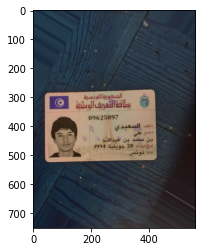

In [4]:
############# CIN recto ############
### correction orientation
image = cv2.imread(r'C:\Users\MSI\Downloads\ali1.jpg')
angle, rotated = correct_orientation(image)
#rotated = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
cv2.imwrite(r'C:\Users\MSI\Downloads\rotated.png', rotated)
plt.imshow(rotated)

67 398


C:\Users\MSI\AppData\Local\Temp/ipykernel_15992/2121848666.py:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


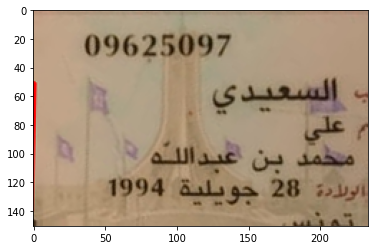

In [5]:
### face detection and virtual contour
os.system('curl -H "apikey:K86104006488957" -o "C:\\Users\\MSI\\Desktop\\processed.json" --form "detectOrientation=true" --form "file=@C:\\Users\\MSI\\Downloads\\rotated.png" --form "language=ara" --form "isOverlayRequired=true" --form "isCreateSearchablePdf=true" --form "scale=true" "https://api.ocr.space/Parse/Image"')
with open(r'C:\Users\MSI\Desktop\processed.json', encoding='utf-8') as f:
    data=json.load(f)
# Load the cascade
face_cascade = cv2.CascadeClassifier(r'C:\Users\MSI\Downloads\haar.xml')
# Read the input image
img = cv2.imread(r'C:\Users\MSI\Downloads\rotated.png')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    print(x,y)
try :
    l = len(data['ParsedResults'][0]['TextOverlay']['Lines'])
    top = [int(data['ParsedResults'][0]['TextOverlay']['Lines'][i]['Words'][0]['Top']) for i in range(l)]
    left = [int(data['ParsedResults'][0]['TextOverlay']['Lines'][i]['Words'][0]['Left']) for i in range(l)]
    max_top, max_left = max(top), max(left)
except (IndexError, KeyError):
    print("Server not responding...\nTrying another method")
    max_top, max_left = y+h+10, 5*w
img_arr = np.array(img)
img_arr = img_arr[y-int(h/2)-10 : max_top+10, x+w : max_left]
angle, img_arr = correct_orientation(img_arr)
# Display the output
cv2.imwrite(r'C:\Users\MSI\Downloads\processed.png',img_arr)
plt.imshow(img_arr)

C:\Users\MSI\AppData\Local\Temp/ipykernel_15992/2030110851.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imgFloat = img_arr.astype(np.float) / 255.


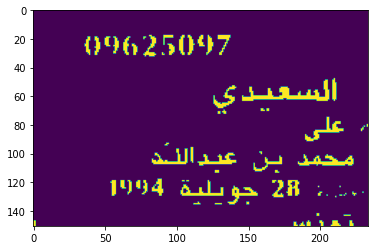

In [6]:
### threshold
imgFloat = img_arr.astype(np.float) / 255.
kChannel = 1 - np.max(imgFloat, axis=2)
kChannel = (255 * kChannel).astype(np.uint8)
binaryThresh = 150
_, binaryImage = cv2.threshold(kChannel, binaryThresh, 255, cv2.THRESH_BINARY)
cv2.imwrite(r'C:\Users\MSI\Downloads\binary.png',binaryImage)
plt.imshow(binaryImage)

In [7]:
### extract information
os.system('curl -H "apikey:K86104006488957" -o "C:\\Users\\MSI\\Desktop\\processed.json" --form "detectOrientation=true" --form "file=@C:\\Users\\MSI\\Downloads\\processed.png" --form "language=ara" --form "isOverlayRequired=true" --form "isCreateSearchablePdf=true" --form "scale=true" "https://api.ocr.space/Parse/Image"')
with open(r'C:\Users\MSI\Desktop\processed.json', encoding='utf-8') as f:
    data=json.load(f)
text = []
try :
    l = len(data['ParsedResults'][0]['TextOverlay']['Lines'])
    for i in range(l):
        line = data['ParsedResults'][0]['TextOverlay']['Lines'][i]['LineText']
        text.append(line)
except (IndexError, KeyError, TypeError) :
    print("Server not responding...\nTrying another method")
    results=arabicocr.arabic_ocr(r'C:\Users\MSI\Downloads\binary.png',r'C:\Users\MSI\Desktop\arabicocr_output.png')
    for i in range(len(results)):	
        text.append(results[i][1])
cin = arabic_reshaper.reshape(text[0])
nom = arabic_reshaper.reshape(text[2]) + ' ' + arabic_reshaper.reshape(text[1])
print(cin+'\n'+nom)

09625097 
ﻋﻠﻲ  ﺍﻟﺴﻌﻴﺪﻱ 


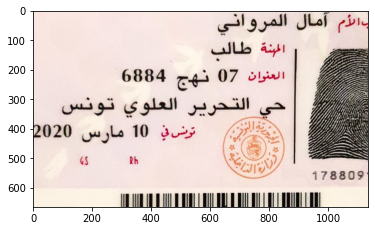

In [8]:
######### CIN verso ###########
img = cv2.imread(r'C:\Users\MSI\Downloads\verso.jpg')
### virtual contour
os.system('curl -H "apikey:K86104006488957" -o "C:\\Users\\MSI\\Desktop\\processed1.json" --form "detectOrientation=true" --form "file=@C:\\Users\\MSI\\Downloads\\verso.jpg" --form "language=ara" --form "isOverlayRequired=true" --form "isCreateSearchablePdf=true" --form "scale=true" "https://api.ocr.space/Parse/Image"')
with open(r'C:\Users\MSI\Desktop\processed1.json', encoding='utf-8') as f:
    data=json.load(f)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
try :
    l = len(data['ParsedResults'][0]['TextOverlay']['Lines'])
    top = [int(data['ParsedResults'][0]['TextOverlay']['Lines'][i]['Words'][len(data['ParsedResults'][0]['TextOverlay']['Lines'][i]['Words'])-1]['Top']) for i in range(l)]
    left = [int(data['ParsedResults'][0]['TextOverlay']['Lines'][i]['Words'][len(data['ParsedResults'][0]['TextOverlay']['Lines'][i]['Words'])-1]['Left']) for i in range(l)]
    top, left = sorted(top, reverse=True), sorted(left, reverse=True)
    #max_top, max_left, min_top, min_left = top[7], max(left), top[len(top)-3]-20, min(left)
    max_top, max_left, min_top, min_left = max(top), max(left), min(top), min(left)
except (IndexError, KeyError, NameError):
    print("Server did not respond")
img_arr = np.array(img)
img_arr = img_arr[min_top : max_top, min_left : max_left]
# Display the output
cv2.imwrite(r'C:\Users\MSI\Downloads\processed1.jpg',img_arr)
plt.imshow(img_arr)

C:\Users\MSI\AppData\Local\Temp/ipykernel_15992/1241371683.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imgFloat = img_arr.astype(np.float) / 255.


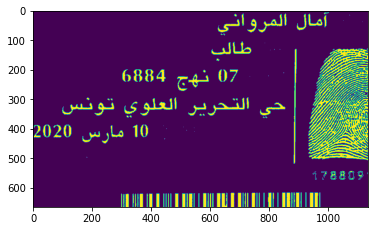

In [9]:
### threshold
imgFloat = img_arr.astype(np.float) / 255.
kChannel = 1 - np.max(imgFloat, axis=2)
kChannel = (255 * kChannel).astype(np.uint8)
binaryThresh = 140
_, binaryImage = cv2.threshold(kChannel, binaryThresh, 255, cv2.THRESH_BINARY)
cv2.imwrite(r'C:\Users\MSI\Downloads\binary1.jpg',binaryImage)
plt.imshow(binaryImage)

In [24]:
### extract information
import difflib
os.system('curl -H "apikey:K86104006488957" -o "C:\\Users\\MSI\\Desktop\\processed1.json" --form "detectOrientation=true" --form "file=@C:\\Users\\MSI\\Downloads\\binary1.jpg" --form "language=ara" --form "isOverlayRequired=true" --form "isCreateSearchablePdf=true" --form "scale=true" "https://api.ocr.space/Parse/Image"')
with open(r'C:\Users\MSI\Desktop\processed1.json', encoding='utf-8') as f:
    data=json.load(f)
verso = []
try :
    l = len(data['ParsedResults'][0]['TextOverlay']['Lines'])
    for i in range(l):
        line = data['ParsedResults'][0]['TextOverlay']['Lines'][i]['LineText']
        verso.append(line)
except (IndexError, KeyError, TypeError) :
    results=arabicocr.arabic_ocr(r'C:\Users\MSI\Downloads\binary1.jpg',r'C:\Users\MSI\Desktop\arabicocr_output.png')
    for i in range(len(results)):
        verso.append(results[i][1])
profession = verso[1]
adresse = (arabic_reshaper.reshape(verso[2]) + '\n' + arabic_reshaper.reshape(verso[3])).replace("()","")
print(profession+'\n'+adresse)

طال 
7 ﻧﻬﺞ 6884 
ﺣﻰ ﺍﻟﺘﺤﺮﻳﺮ ﺍﻟﻌﻠﻮﻱ ﺗﻮﻧﺲ 


In [30]:
"""
for i in range(len(results)):
    l = [results[i][1]]
    for j in range(len(results)):
        c=0
        if(i==j):
            continue
        for k in range(4):
            if abs(results[i][0][k][1]-results[j][0][k][1])<=20:
                c+=1
        if(c>=3):
            l.append(results[j][1])
    print(l)
"""

'\nfor i in range(len(results)):\n    l = [results[i][1]]\n    for j in range(len(results)):\n        c=0\n        if(i==j):\n            continue\n        for k in range(4):\n            if abs(results[i][0][k][1]-results[j][0][k][1])<=20:\n                c+=1\n        if(c>=3):\n            l.append(results[j][1])\n    print(l)\n'

1118 127 202 144
[ 35.618187  43.675358 190.70912 ]
1172 136 123 121


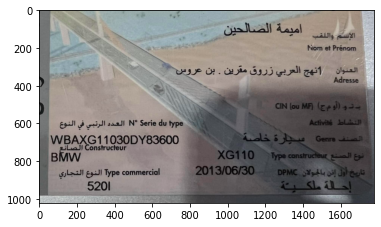

In [31]:
############ carte grise #############
gr = cv2.imread(r'C:\Users\MSI\Downloads\cg12.jpg')
dimensions = gr.shape
height = gr.shape[0]
width = gr.shape[1]
selected = False
image = cv2.cvtColor(gr, cv2.COLOR_BGR2HSV)

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])

# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

lower_mask = cv2.inRange(image, lower1, upper1)
upper_mask = cv2.inRange(image, lower2, upper2)

full_mask = lower_mask + upper_mask

contours, hierarchy = cv2.findContours(
    full_mask, cv2.RETR_TREE,  cv2.CHAIN_APPROX_SIMPLE)
"""cv2.RETR_TREE"""
h, w = gr.shape[:2]
thresh_area = 0.001
list_contours = list()
for c in contours:
    area = cv2.contourArea(c)

    if (area > thresh_area*h*w):
        rect_page = cv2.minAreaRect(c)
        box_page = np.int0(cv2.boxPoints(rect_page))
        list_contours.append(box_page)

sorted_contours = sorted(list_contours, key=cv2.contourArea, reverse=True)
#
for (i, c) in enumerate(sorted_contours):
    x, y, w, h = cv2.boundingRect(c)
    print(x, y, w, h)
    #
    if(w > h) & (h*2 > w) & (h < 800) & (w < 800) & (x > 0) & (y > 0) & (x+w <= width) & (y+h <= height) & (selected == False):
        cropped_contour = gr[y:y+h, x:x+w]
        # pour savoir la couleur domiante
        pixels = np.float32(cropped_contour.reshape(-1, 3))
        n_colors = 7
        criteria = (cv2.TERM_CRITERIA_EPS +
                    cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS
        _, labels, palette = cv2.kmeans(
            pixels, n_colors, None, criteria, 10, flags)
        _, counts = np.unique(labels, return_counts=True)
        dominant = palette[np.argmax(counts)]
        print(dominant)
        # si le rouge est plus dominant que le vert
        if(dominant[1]*1.8 < dominant[2]):
            selected = True
            # Si le drapeau existe l'image finale est correcte
            #cv2.imshow('Flag', cropped_contour)
            #cv2.imwrite("contour11.jpg", cropped_contour)
            # cv2.waitKey(0)
            Top = round(y+h*1.1)

            Bottom = round(y+h*8.2)
            if(Bottom > height):
                Bottom = height
            Left = round(x-w*4.3)
            if(Left < 0):
                Left = 0
            Right = round(x+w*4.5)
            if(Right > width):
                Right = width

            final_pic = gr[Top:Bottom, Left:Right]
            cv2.imwrite(r'C:\Users\MSI\Downloads\zoomed_carte_grise.jpg', final_pic)
            plt.imshow(final_pic)

In [37]:
### OCRing
date_pattern = '^([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])$'
serie_type, dpmc = '', ''
langs = "ar,en".split(",")
reader = Reader(langs, gpu=-1 > 0)
results = reader.readtext(final_pic)
for (bbox, text, prob) in results:
    if any(x.isalpha() for x in text) and any(x.isnumeric() for x in text) and len(text)>9:
        serie_type = text
    if re.match(date_pattern, text):
        dpmc = text
print("N° de série du type : {}\nDPMC : {}".format(serie_type,dpmc))

Using CPU. Note: This module is much faster with a GPU.


N° de série du type : WBAXG110300Y83600
DPMC : 2013/06/30


In [39]:
####### serialization #######

d = {
    "cin": cin,
    "nom": nom,
    "profession": profession,
    "adresse": adresse,
    "serie_type": serie_type,
    "dpmc": dpmc
}

json_object = json.dumps(d,indent=4)
with open(r'C:\Users\MSI\Desktop\data.json',"w",encoding="utf-8") as out:
    out.write(json_object)
out.close()
print(d)

{'cin': '09625097 ', 'nom': 'ﻋﻠﻲ  ﺍﻟﺴﻌﻴﺪﻱ ', 'profession': 'طال ', 'adresse': '7 ﻧﻬﺞ 6884 \nﺣﻰ ﺍﻟﺘﺤﺮﻳﺮ ﺍﻟﻌﻠﻮﻱ ﺗﻮﻧﺲ ', 'serie_type': 'WBAXG110300Y83600', 'dpmc': '2013/06/30'}


In [47]:
######### contract #########

font2 = ImageFont.truetype("arial.ttf", 16, encoding="utf-8")
font = ImageFont.truetype("arial.ttf", 20, encoding="utf-8")
text_width, text_height = font.getsize(nom)
canvas = Image.open(r'C:\Users\MSI\Downloads\contrat.jpg')
canvas=canvas.convert('RGB')
draw = ImageDraw.Draw(canvas)
draw.text((400, 615), cin, 'black', font)
draw.text((400, 745), cin, 'black', font)
draw.text((400, 540), get_display(nom), 'black', font)
draw.text((400, 570), get_display(adresse), 'black', font)
draw.text((400, 703), get_display(adresse), 'black', font)
draw.text((400, 770), get_display(profession), 'black', font)
draw.text((400, 685), get_display(nom), 'black', font)
draw.text((400, 865), serie_type, 'black', font2)
draw.text((400, 981), dpmc, 'black', font2)
canvas.save(r'C:\Users\MSI\Desktop\contrat.png', "PNG")
canvas.show()